## Download Data

In [3]:
required_data_url = [
    "https://figshare.com/ndownloader/files/37729413",
    "https://figshare.com/ndownloader/files/37729416",
    "https://figshare.com/ndownloader/files/37729419"
]

# Download and placed it to data folder
import os

data_folder = os.path.abspath("data")
# Do the download using urllib
for url in required_data_url:
    # Download using curl
    os.system(f"curl -O -J -L {url} --output-dir {data_folder}/")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 20.6M  100 20.6M    0     0  2150k      0  0:00:09  0:00:09 --:--:-- 1835k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.5M  100 10.5M    0     0  2945k      0  0:00:03  0:00:03 --:--:-- 3268k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 90592  100 90592    0     0   199k      0 --:--:-- --:--:-- --:--:--  199k


## Raster Calculation

In [1]:
import rioxarray as rxr

In [2]:
import pystac

In [8]:
api_url = "https://earth-search.aws.element84.com/v1"

collection = "sentinel-2-l2a"

In [9]:
from pystac_client import Client

client = Client.open(api_url)

In [10]:
from shapely.geometry import Point
point = Point(4.89, 52.37)  # AMS coordinates

In [11]:
bbox = point.buffer(0.01).bounds

In [12]:
search = client.search(
    collections=[collection],
    bbox=bbox,
    datetime="2020-03-20/2020-03-30",
    query=["eo:cloud_cover<10"]
)
print(search.matched())

4


In [13]:
items = search.item_collection()
items.save_object("search.json")

In [14]:
items = pystac.ItemCollection.from_file("search.json")

In [15]:
items

In [18]:
red_uri = items[1].assets["red"].href
nir_uri = items[1].assets["nir08"].href

import rioxarray
red = rioxarray.open_rasterio(red_uri, masked=True)
nir = rioxarray.open_rasterio(nir_uri, masked=True)

bbox = (629_000, 5_804_000, 639_000, 5_814_000)
red_clip = red.rio.clip_box(*bbox)
nir_clip = nir.rio.clip_box(*bbox)

In [19]:
bbox = (629_000, 5_804_000, 639_000, 5_814_000)
red_clip = red.rio.clip_box(*bbox)
nir_clip = nir.rio.clip_box(*bbox)

In [20]:
red_clip_matched = red_clip.rio.reproject_match(nir_clip)
print(red_clip_matched.shape)

(1, 500, 500)


In [21]:
ndvi = (nir_clip - red_clip_matched)/ (nir_clip + red_clip_matched)
print(ndvi)

<xarray.DataArray (band: 1, y: 500, x: 500)> Size: 1MB
array([[[ 0.7379576 ,  0.77153456,  0.54531944, ...,  0.39254385,
          0.49227372,  0.4465174 ],
        [ 0.7024894 ,  0.7074668 ,  0.3903298 , ...,  0.423283  ,
          0.4706971 ,  0.45964912],
        [ 0.6557818 ,  0.5610572 ,  0.46742022, ...,  0.4510345 ,
          0.43815723,  0.6005133 ],
        ...,
        [ 0.02391171,  0.21843003,  0.02479339, ..., -0.50923485,
         -0.53367877, -0.4955414 ],
        [ 0.11376493,  0.17681159, -0.1673566 , ..., -0.5221932 ,
         -0.5271318 , -0.4852753 ],
        [ 0.45398772, -0.00518135,  0.03346133, ..., -0.5019455 ,
         -0.4987013 , -0.49081364]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 4kB 6.29e+05 6.29e+05 ... 6.39e+05 6.39e+05
  * y            (y) float64 4kB 5.814e+06 5.814e+06 ... 5.804e+06 5.804e+06
    spatial_ref  int64 8B 0


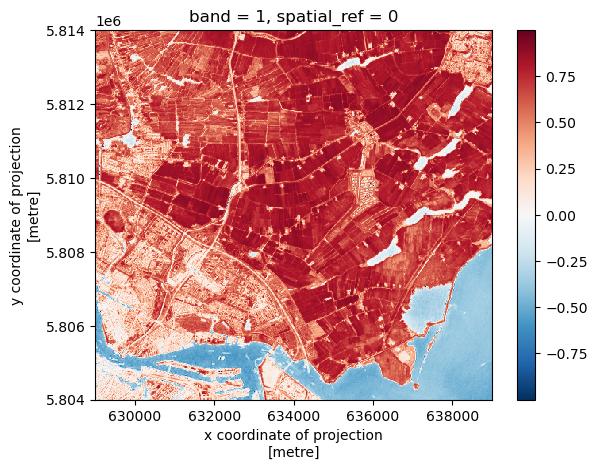

In [22]:
ndvi.plot()

In [23]:
ndvi_nonan = ndvi.interpolate_na(dim="x")

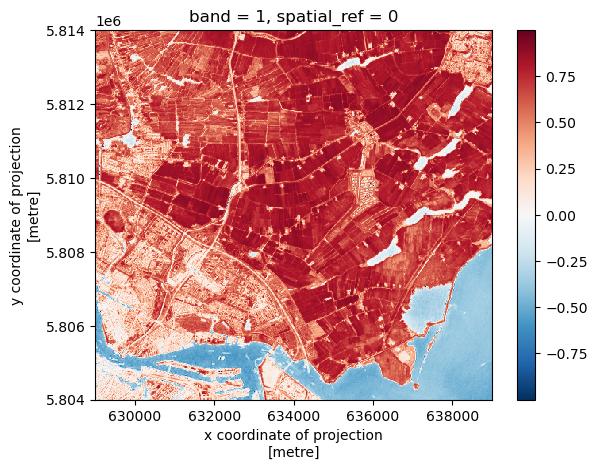

In [24]:
ndvi_nonan.plot()

In [25]:
ndvi_nonan.rio.to_raster("NDVI.tif")

In [26]:
import numpy as np
import xarray

# Defines the bins for pixel values
class_bins = (-1, 0., 0.2, 0.7, 1)

# The numpy.digitize function returns an unlabeled array, in this case, a
# classified array without any metadata. That doesn't work--we need the
# coordinates and other spatial metadata. We can get around this using
# xarray.apply_ufunc, which can run the function across the data array while
# preserving metadata.
ndvi_classified = xarray.apply_ufunc(
    np.digitize,
    ndvi_nonan,
    class_bins
)

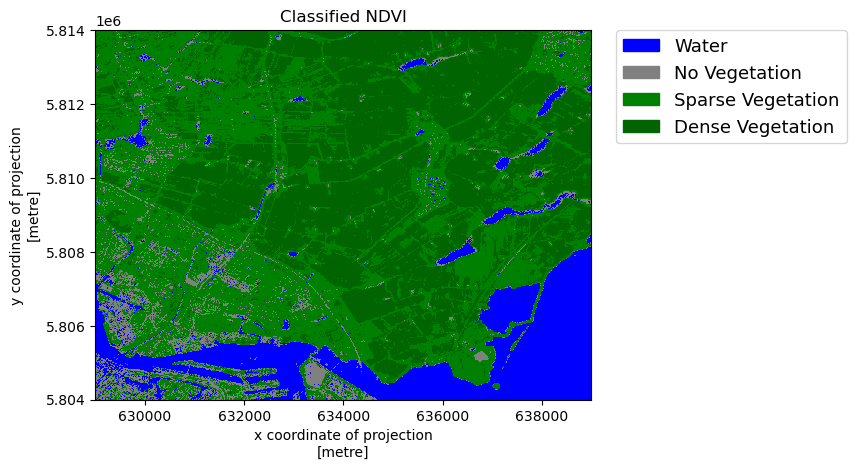

In [27]:
import earthpy.plot as ep
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

# Define color map of the map legend
ndvi_colors = ["blue", "gray", "green", "darkgreen"]
ndvi_cmap = ListedColormap(ndvi_colors)

# Define class names for the legend
category_names = [
    "Water",
    "No Vegetation",
    "Sparse Vegetation",
    "Dense Vegetation"
]

# We need to know in what order the legend items should be arranged
category_indices = list(range(len(category_names)))

# Make the plot
im = ndvi_classified.plot(cmap=ndvi_cmap, add_colorbar=False)
plt.title("Classified NDVI")
# earthpy helps us by drawing a legend given an existing image plot and legend items, plus indices
ep.draw_legend(im_ax=im, classes=category_indices, titles=category_names)

# Save the figure
plt.savefig("NDVI_classified.png", bbox_inches="tight", dpi=300)

In [28]:
ndvi_classified.rio.to_raster("NDVI_classified.tif", dtype="int32")

## Vector Operation

In [16]:
import geopandas as gpd

In [30]:
fields = gpd.read_file("data/brpgewaspercelen_definitief_2020_small.gpkg")
fields

,category,gewas,gewascode,jaar,status,geometry
0,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((117626.809 505287.535, 117622.93 505..."
1,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((117744.449 504313.788, 117746.064 50..."
2,Grasland,"Grasland, natuurlijk. Hoofdfunctie landbouw.",331,2020,Definitief,"POLYGON ((117784.216 503525.695, 117789.021 50..."
3,Grasland,"Grasland, natuurlijk. Hoofdfunctie landbouw.",331,2020,Definitief,"POLYGON ((117903.681 504159.929, 117908.257 50..."
4,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((118150.139 505369.637, 118168.01 505..."
...,...,...,...,...,...,...
22026,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((139366.829 479190.018, 139391.354 47..."
22027,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((138750.889 478528.117, 138722.478 47..."
22028,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((139214.523 479446.287, 139104.402 47..."
22029,Bouwland,"Maïs, snij-",259,2020,Definitief,"POLYGON ((140196.363 479281.898, 140195.206 47..."


In [31]:
# Define bounding box
xmin, xmax = (110_000, 140_000)
ymin, ymax = (470_000, 510_000)
bbox = (xmin, ymin, xmax, ymax)

In [32]:
# Partially load data within the bounding box
fields = gpd.read_file("data/brpgewaspercelen_definitief_2020_small.gpkg", bbox=bbox)

<Axes: >

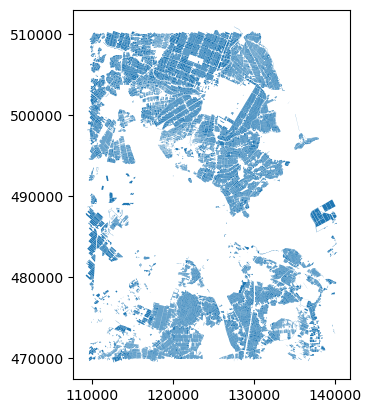

In [34]:
fields.plot()

In [35]:
# A smaller bounding box in RD
xmin, xmax = (120_000, 135_000)
ymin, ymax = (485_000, 500_000)

fields_cx = fields.cx[xmin:xmax, ymin:ymax]

In [36]:
fields_cx.to_file('fields_cropped.shp')

<Axes: >

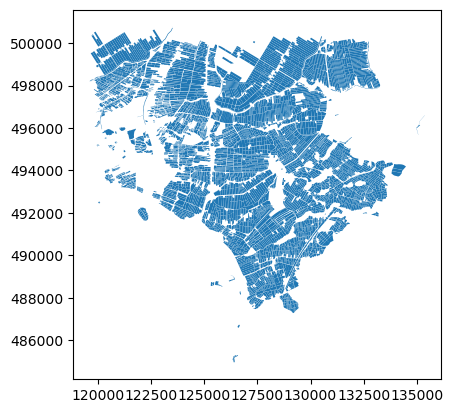

In [37]:
fields_cx.plot()